In [326]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter

In [327]:
r = 13

galaxy_title = 'NGC 5253'
galaxy_file = galaxy_title.replace(' ', '_')

line_name = '[OIII]'

line_measurement = 0
addendum = ''

if line_name == '[OIII]':
    line_measurement = 52
    addendum = 'sw_1'
    
if line_name == '[NIII]':
    line_measurement = 57
    addendum = 'sw_2'

titlename = galaxy_title + ' ' + line_name + ' ' + str(line_measurement) + ' ' + r'$\mu$m, r = {}'.format(str(r))
filename = galaxy_file + '_' + line_name + '_r={}'.format(str(r))

In [328]:
loaddir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/' + galaxy_file + '_' + addendum + '/'

savedir = loaddir + 'r=' + str(r) + '/'

fits_name = galaxy_file + '_' + addendum + '.fits'
fits_spec_name = galaxy_file + '_' + addendum + '_r={}.fits'.format(str(r))

In [329]:
hdulist = fits.open(loaddir + fits_name)

hdulist.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_5253_sw_1/NGC_5253_sw_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     311   ()      
  1  FLUX          1 ImageHDU        28   (33, 35, 56)   float64   
  2  ERROR         1 ImageHDU        28   (33, 35, 56)   float64   
  3  UNCORRECTED_FLUX    1 ImageHDU        28   (33, 35, 56)   float64   
  4  UNCORRECTED_ERROR    1 ImageHDU        28   (33, 35, 56)   float64   
  5  WAVELENGTH    1 ImageHDU         7   (56,)   float64   
  6  X             1 ImageHDU         7   (33,)   float64   
  7  Y             1 ImageHDU         7   (35,)   float64   
  8  TRANSMISSION    1 ImageHDU         7   (56,)   float64   
  9  RESPONSE      1 ImageHDU         7   (56,)   float32   
 10  EXPOSURE_MAP    1 ImageHDU        28   (33, 35, 56)   int16   
 11  UNSMOOTHED_TRANSMISSION    1 ImageHDU         8   (1540, 2)   float32   


In [330]:
hdulist[1].header

XTENSION= 'IMAGE   '           /extension type                                  
BITPIX  =                  -64 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                   33 /                                                
NAXIS2  =                   35 /                                                
NAXIS3  =                   56 /                                                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                
EXTNAME = 'FLUX    '           /                                                
DATE-OBS= '2019-05-10T05:54:03' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =              2000.00 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'        

In [331]:
hdulist_spec = fits.open(savedir + fits_spec_name)
hdulist_spec.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_5253_sw_1/r=13/NGC_5253_sw_1_r=13.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FLUX          1 PrimaryHDU      28   (56,)   float32   


In [332]:
wavelengths = hdulist[5].data

print(wavelengths)

wav_diff = []

for i in range(0, len(wavelengths)-1):
    wav_diff.append(wavelengths[i+1]-wavelengths[i])
  
wav_diff = np.average(wav_diff)

print(wav_diff)

[51.69096047 51.69816742 51.70537437 51.71258132 51.71978827 51.72699522
 51.73420216 51.74140911 51.74861606 51.75582301 51.76302996 51.77023691
 51.77744386 51.7846508  51.79185775 51.7990647  51.80627165 51.8134786
 51.82068555 51.8278925  51.83509944 51.84230639 51.84951334 51.85672029
 51.86392724 51.87113419 51.87834114 51.88554808 51.89275503 51.89996198
 51.90716893 51.91437588 51.92158283 51.92878978 51.93599672 51.94320367
 51.95041062 51.95761757 51.96482452 51.97203147 51.97923842 51.98644536
 51.99365231 52.00085926 52.00806621 52.01527316 52.02248011 52.02968706
 52.036894   52.04410095 52.0513079  52.05851485 52.0657218  52.07292875
 52.0801357  52.08734264]
0.0072069485786618705


In [333]:
central_fluxes_unfiltered = hdulist_spec[0].data
    
central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

c = 3*10**8

for i in range(0, len(wavelengths)):
    
    wavelength = wavelengths[i]
    
    central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))
    
central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)

In [334]:
lower_ind = 13
upper_ind = -14

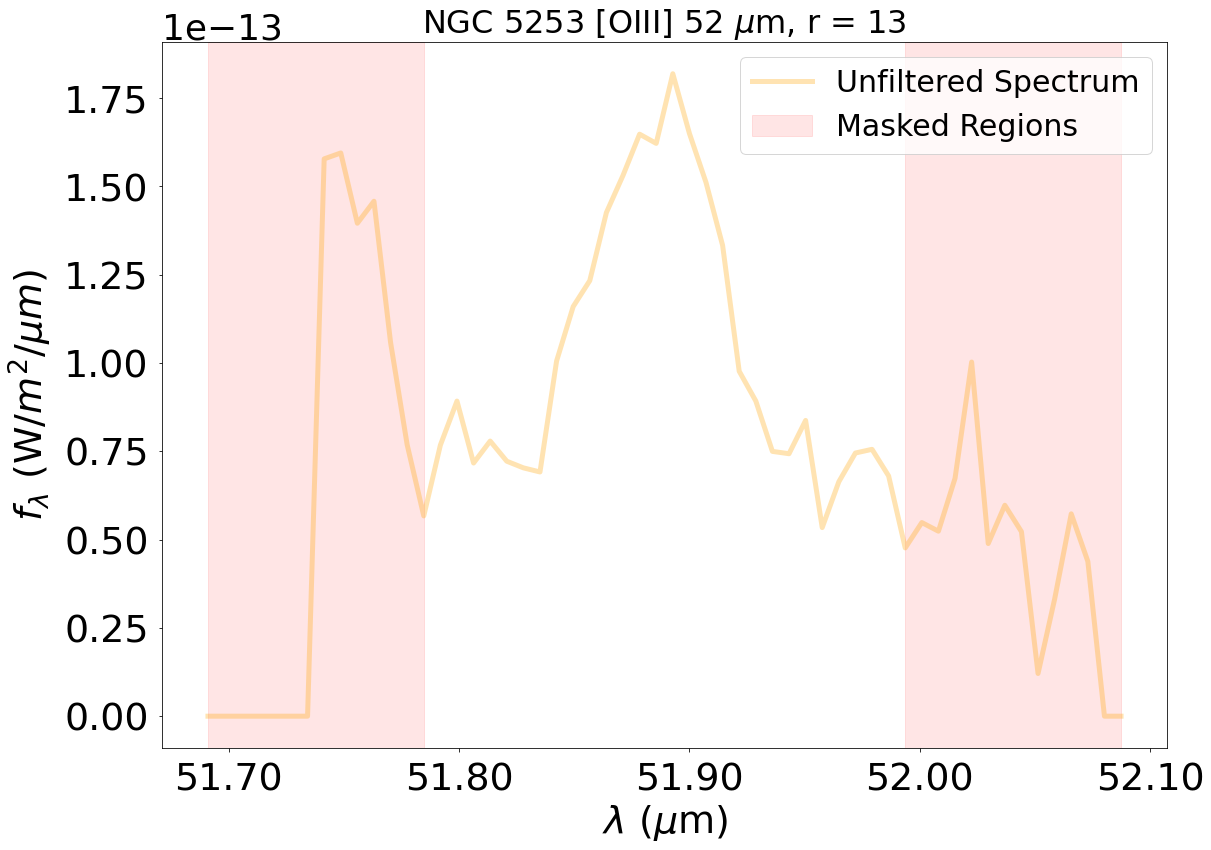

In [335]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.axvspan(wavelengths[0], wavelengths[lower_ind], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax.axvspan(wavelengths[upper_ind], wavelengths[-1], color = 'red', alpha = 0.1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

plt.savefig(savedir + filename + '-1-unfiltered_spectrum.png'.format(str(r)))

ax.legend(prop={'size': 30}, loc = 'upper right')

In [336]:
print(central_fluxes_unfiltered)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.57800101e-13
 1.59475603e-13 1.39573011e-13 1.45807521e-13 1.05815858e-13
 7.68372058e-14 5.67070878e-14 7.67525478e-14 8.92175611e-14
 7.16767616e-14 7.79023750e-14 7.21906572e-14 7.03141683e-14
 6.91474427e-14 1.00565338e-13 1.15979321e-13 1.23330585e-13
 1.42595757e-13 1.53108734e-13 1.64794034e-13 1.62185089e-13
 1.81906685e-13 1.65018657e-13 1.51124979e-13 1.33308531e-13
 9.76704660e-14 8.92370274e-14 7.49759003e-14 7.43159553e-14
 8.37379799e-14 5.34036360e-14 6.63706751e-14 7.45165899e-14
 7.55600875e-14 6.80240461e-14 4.76402474e-14 5.48255707e-14
 5.23785552e-14 6.73434630e-14 1.00272687e-13 4.88861064e-14
 5.97234427e-14 5.22489706e-14 1.20856310e-14 3.31629835e-14
 5.72901200e-14 4.38199476e-14 0.00000000e+00 0.00000000e+00]


In [337]:
central_fluxes_filtered = central_fluxes_unfiltered

wavelengths_filtered = wavelengths[lower_ind:upper_ind+1]
central_fluxes_filtered = central_fluxes_filtered[lower_ind:upper_ind+1]

print(central_fluxes_filtered)

[5.67070878e-14 7.67525478e-14 8.92175611e-14 7.16767616e-14
 7.79023750e-14 7.21906572e-14 7.03141683e-14 6.91474427e-14
 1.00565338e-13 1.15979321e-13 1.23330585e-13 1.42595757e-13
 1.53108734e-13 1.64794034e-13 1.62185089e-13 1.81906685e-13
 1.65018657e-13 1.51124979e-13 1.33308531e-13 9.76704660e-14
 8.92370274e-14 7.49759003e-14 7.43159553e-14 8.37379799e-14
 5.34036360e-14 6.63706751e-14 7.45165899e-14 7.55600875e-14
 6.80240461e-14 4.76402474e-14]


In [338]:
central_fluxes_filtered_continuum = []

left_cut = 51.835
right_cut = 51.945

for i in range(0, len(wavelengths_filtered)):
    
    wavelength = wavelengths_filtered[i]
    
    if(wavelength < left_cut or wavelength > right_cut):
        central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])
    
    else:
        central_fluxes_filtered_continuum.append(float("Nan"))
        
central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

print(central_fluxes_filtered_continuum)

[5.67070878e-14 7.67525478e-14 8.92175611e-14 7.16767616e-14
 7.79023750e-14 7.21906572e-14 7.03141683e-14            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan 8.37379799e-14
 5.34036360e-14 6.63706751e-14 7.45165899e-14 7.55600875e-14
 6.80240461e-14 4.76402474e-14]


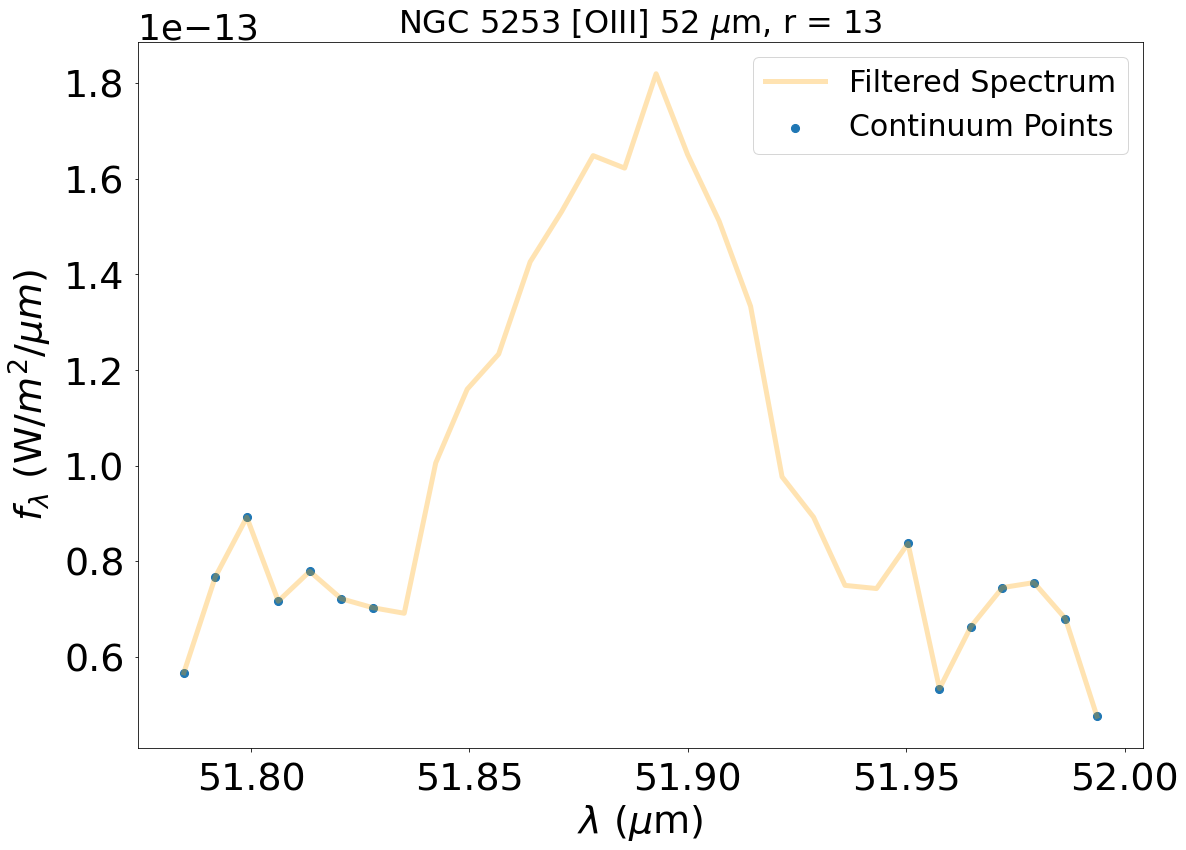

In [339]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + filename + '-2-filtered_spectrum + continuum_points.png'.format(str(r)))

In [340]:
idcont = np.isfinite(central_fluxes_filtered_continuum)
cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)

print(cont_params)

cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]

[-4.16680662e-14  2.23240735e-12]


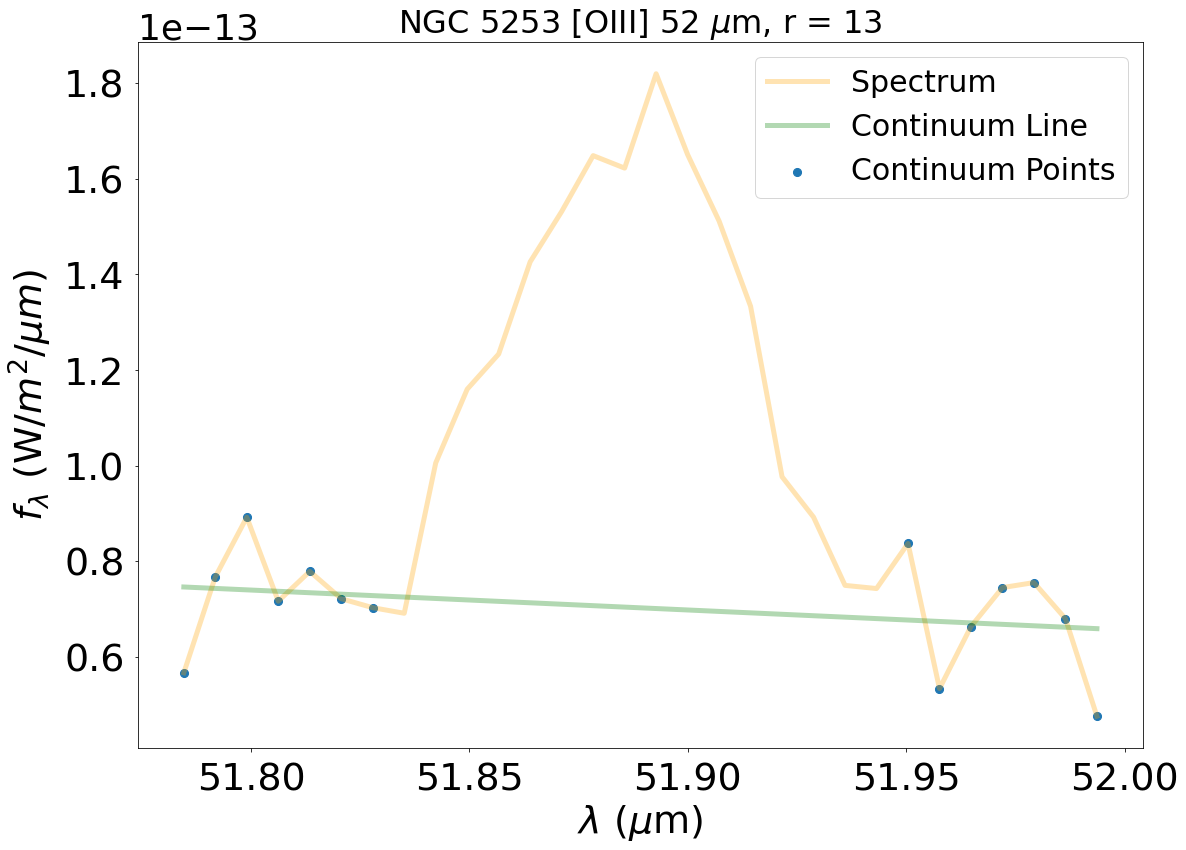

In [341]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + filename + '-3-filtered_spectrum + continuum_line.png'.format(str(r)))

In [342]:
id_act = np.isnan(central_fluxes_filtered_continuum)

wavelengths_act = wavelengths_filtered[id_act]
central_fluxes_filtered_act = central_fluxes_filtered[id_act]
cont_line_filtered_act = cont_line_filtered[id_act]

central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act

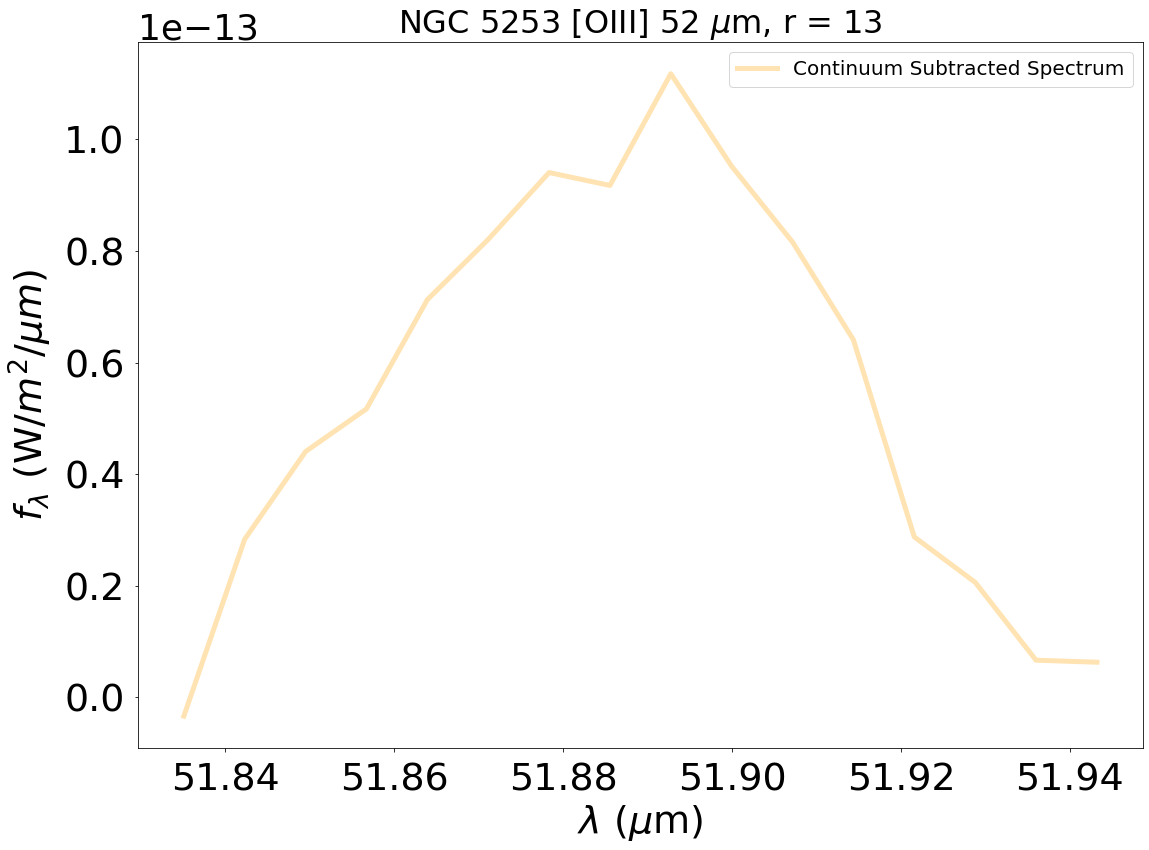

In [343]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + filename + '-4-continuum_subtracted_spectrum.png'.format(str(r)))

In [344]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [345]:
heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

centers = wavelengths_act

# Information about the peak in the numerical PDF
peak_ind = np.where(heights == np.max(heights))[0][0]
peak_height = np.max(heights)

# mu is where the numerical PDF peaks
mu = centers[peak_ind]

# Estimating sigma using FWHM
sigma = 0

for i in range(0, peak_ind):
    if(heights[i] >= peak_height/2):
        sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
        break

# First fit a Gaussian

guess_params = np.array([peak_height, sigma])
fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                           fit_func_1(centers, peak_height, mu, sigma), 
                                           centers, heights, p0=guess_params)

fit_params = [fit_params[0], mu, fit_params[1]]

fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)

print(fit_params)

[1.0306689664962996e-13, 51.8927550323445, 0.02501230170562374]


[7.23304389e-15 7.92497342e-15 8.66922631e-15 9.46822737e-15
 1.03243526e-14 1.12399089e-14 1.22171123e-14 1.32580653e-14
 1.43647328e-14 1.55389176e-14 1.67822346e-14 1.80960848e-14
 1.94816291e-14 2.09397615e-14 2.24710829e-14 2.40758754e-14
 2.57540766e-14 2.75052560e-14 2.93285919e-14 3.12228502e-14
 3.31863654e-14 3.52170236e-14 3.73122482e-14 3.94689888e-14
 4.16837127e-14 4.39524005e-14 4.62705453e-14 4.86331554e-14
 5.10347616e-14 5.34694289e-14 5.59307718e-14 5.84119751e-14
 6.09058183e-14 6.34047050e-14 6.59006960e-14 6.83855477e-14
 7.08507529e-14 7.32875868e-14 7.56871558e-14 7.80404495e-14
 8.03383949e-14 8.25719140e-14 8.47319819e-14 8.68096869e-14
 8.87962913e-14 9.06832918e-14 9.24624801e-14 9.41260019e-14
 9.56664147e-14 9.70767428e-14 9.83505304e-14 9.94818903e-14
 1.00465549e-13 1.01296890e-13 1.01971984e-13 1.02487628e-13
 1.02841363e-13 1.03031499e-13 1.03057126e-13 1.02918121e-13
 1.02615149e-13 1.02149660e-13 1.01523874e-13 1.00740766e-13
 9.98040418e-14 9.871810

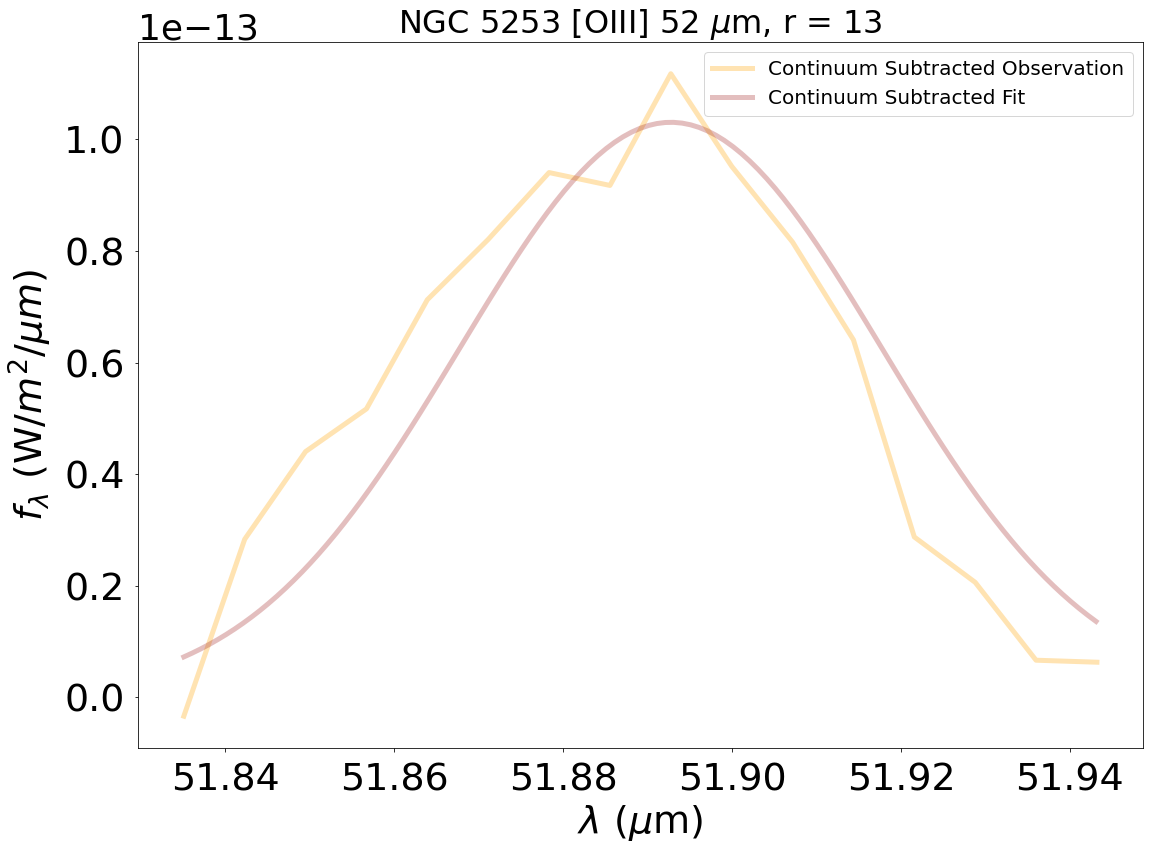

In [346]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), 0.001)

fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelength_range, *fit_params)

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

ax.plot(wavelength_range, fitted_central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + filename + '-5-fit_continuum_subtracted_spectrum.png'.format(str(r)))

[7.23304389e-15 7.92497342e-15 8.66922631e-15 9.46822737e-15
 1.03243526e-14 1.12399089e-14 1.22171123e-14 1.32580653e-14
 1.43647328e-14 1.55389176e-14 1.67822346e-14 1.80960848e-14
 1.94816291e-14 2.09397615e-14 2.24710829e-14 2.40758754e-14
 2.57540766e-14 2.75052560e-14 2.93285919e-14 3.12228502e-14
 3.31863654e-14 3.52170236e-14 3.73122482e-14 3.94689888e-14
 4.16837127e-14 4.39524005e-14 4.62705453e-14 4.86331554e-14
 5.10347616e-14 5.34694289e-14 5.59307718e-14 5.84119751e-14
 6.09058183e-14 6.34047050e-14 6.59006960e-14 6.83855477e-14
 7.08507529e-14 7.32875868e-14 7.56871558e-14 7.80404495e-14
 8.03383949e-14 8.25719140e-14 8.47319819e-14 8.68096869e-14
 8.87962913e-14 9.06832918e-14 9.24624801e-14 9.41260019e-14
 9.56664147e-14 9.70767428e-14 9.83505304e-14 9.94818903e-14
 1.00465549e-13 1.01296890e-13 1.01971984e-13 1.02487628e-13
 1.02841363e-13 1.03031499e-13 1.03057126e-13 1.02918121e-13
 1.02615149e-13 1.02149660e-13 1.01523874e-13 1.00740766e-13
 9.98040418e-14 9.871810

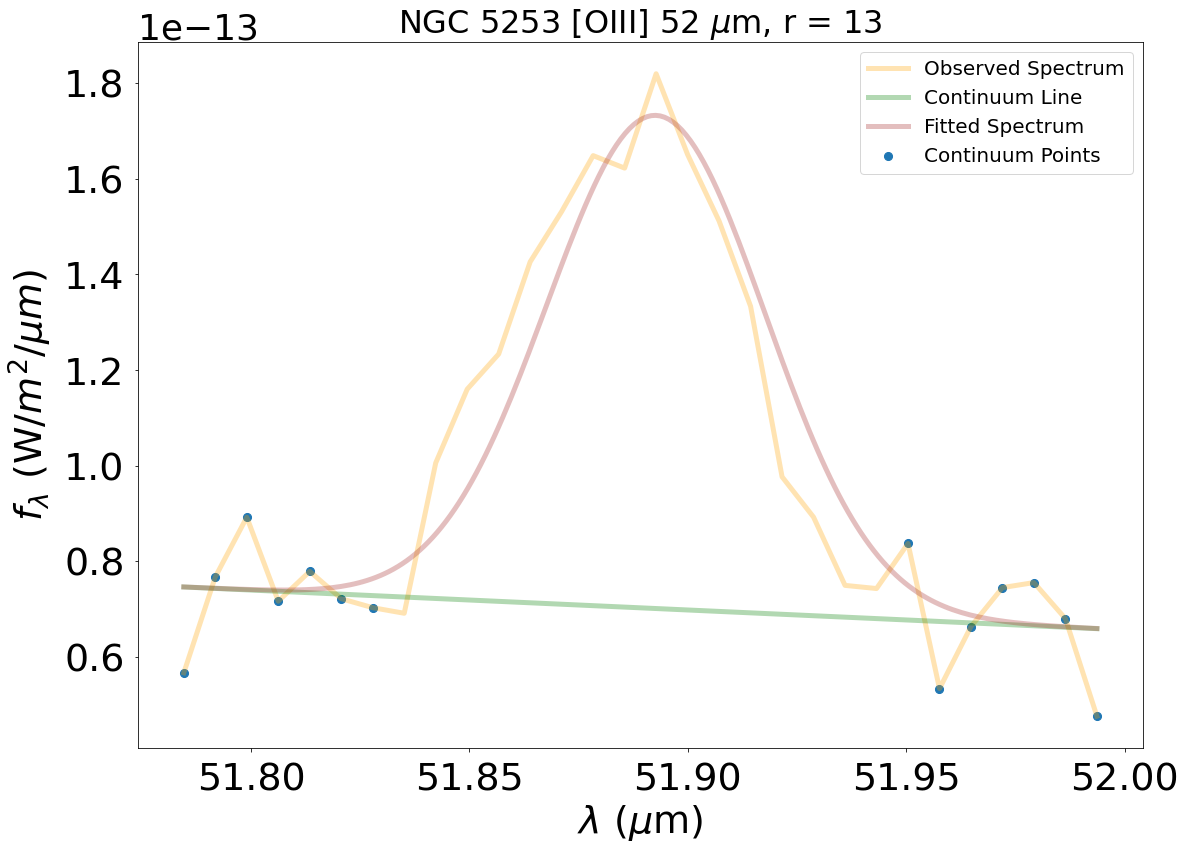

In [347]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]

fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + filename + '-6-final_spectrum.png'.format(str(r)))

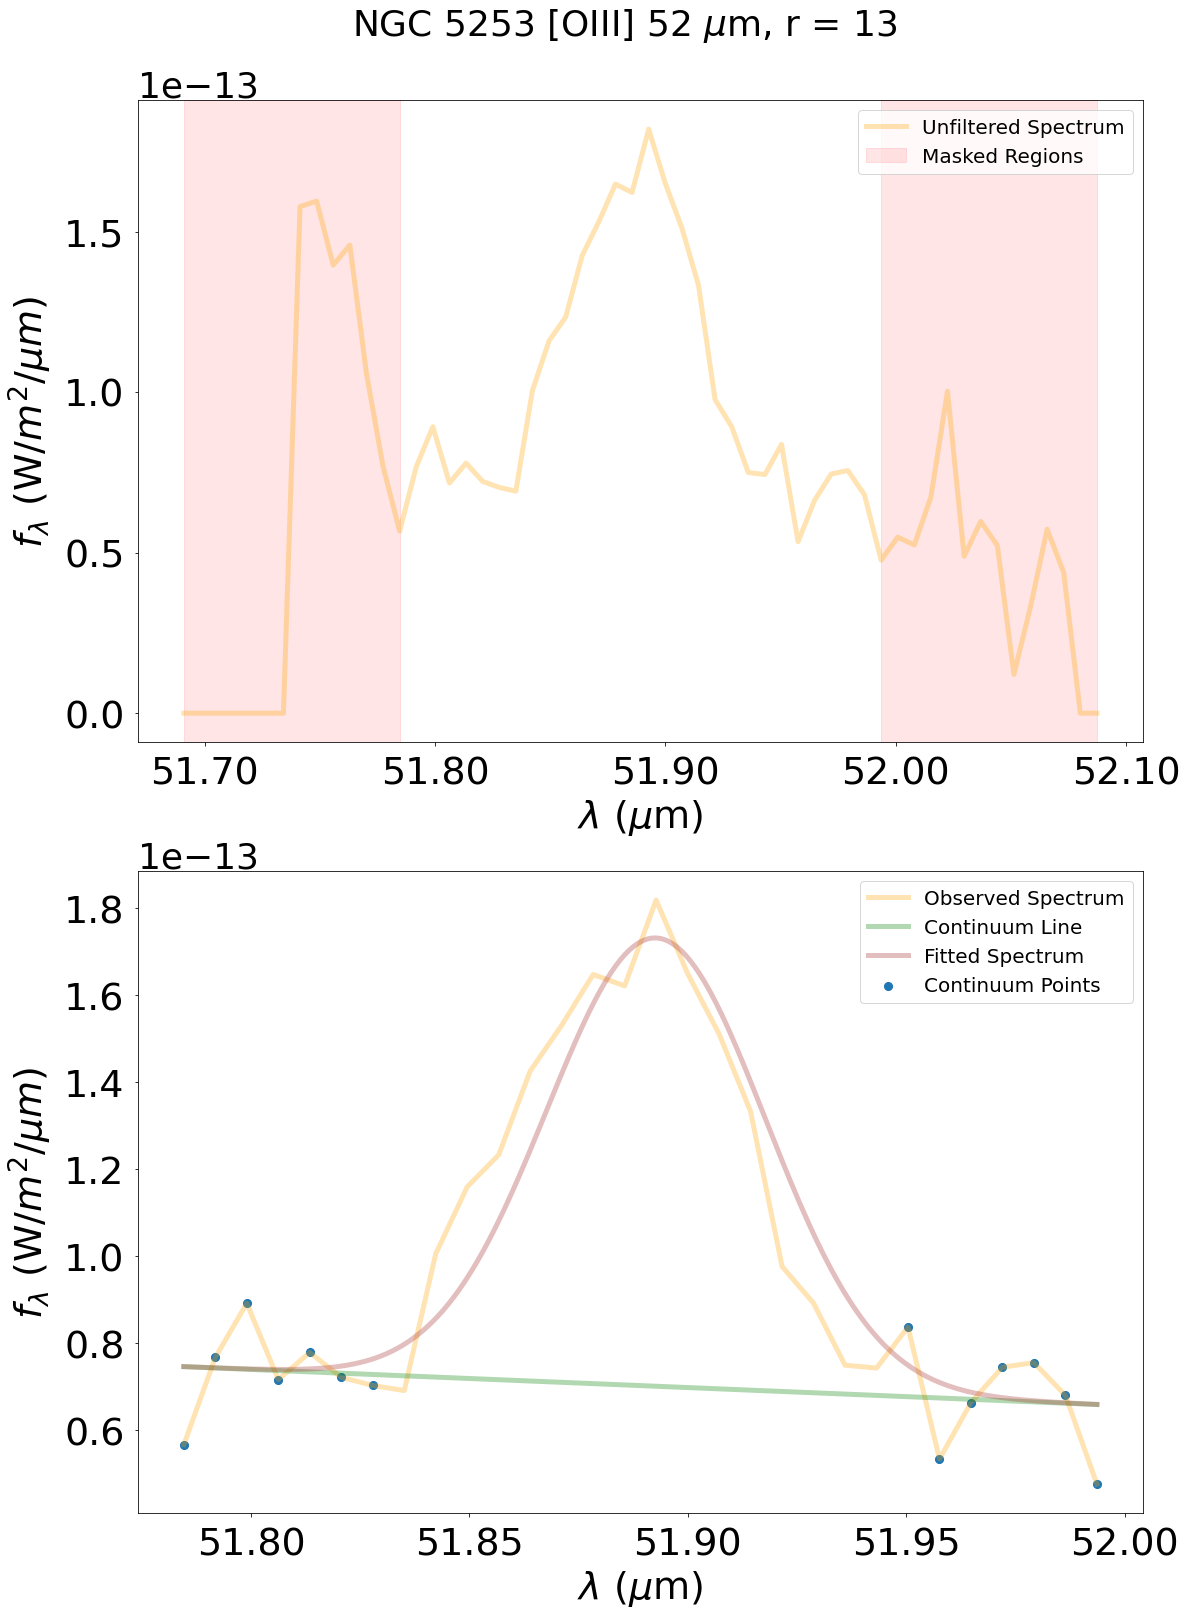

In [348]:
fig, axs = plt.subplots(2, 1, figsize = (18, 26))

ax1 = axs[0]

ax1.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax1.axvspan(wavelengths[0], wavelengths[13], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax1.axvspan(wavelengths[-14], wavelengths[-1], color = 'red', alpha = 0.1)

ax1.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax1.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.tick_params(labelsize = 38, pad = 10)
ax1.yaxis.offsetText.set_fontsize(36)
ax1.legend(prop={'size': 20}, loc = 'upper right')

ax2 = axs[1]

ax2.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax2.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax2.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax2.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax2.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax2.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax2.tick_params(labelsize = 38, pad = 10)
ax2.yaxis.offsetText.set_fontsize(36)
ax2.legend(prop={'size': 20}, loc = 'upper right')

fig.suptitle(titlename, fontsize = 36, y = 0.93)

plt.savefig(savedir + filename + '-7-summary_spectrum.png'.format(str(r)))

In [349]:
flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
flux_obs_sub = flux_obs - flux_continuum

flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
flux_fit_sub = flux_fit - flux_continuum

In [350]:
f = open(savedir + filename + "_measurements.txt".format(str(r)), "w")
f.write('Flux of the continuum = ' + str(flux_continuum) + ' W/m^2 \n')
f.write('Flux of the continuum subtracted observation = ' + str(flux_obs_sub) + ' W/m^2 \n')
f.write('Flux of the continuum subtracted fit = ' + str(flux_fit_sub) + ' W/m^2 \n')
f.write('FWHM of fitted Gaussian = ' + str(str(2*np.sqrt(np.log(2))*fit_params[2])) + r' microns')
f.close()